<a href="https://colab.research.google.com/github/AmedeeRoy/BirdDL/blob/main/code/LB/15s/LB_fcn_lonlatcov_21_1_15s.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dive Prediction - Deep Network

*Predicting Seabird Diving Behaviour from GPS data*

This notebook trains a neural network to predict seabirds' dives.

Networks' characteristics:

* *Trajectory window* : 11 x 5s
* *Output resolution*: 1 x 55s
* *Representation of trajectories* : Time series
* *Layers* : convolutions

## connect to drive

In [1]:
# mount google drive
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [2]:
%cd drive/My\ Drive/

/content/drive/My Drive


## load data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from utils.trip import * 

In [4]:
data_train = pd.read_csv('./data/LB_train.csv')
data_validation = pd.read_csv('./data/LB_validation.csv')
data_test = pd.read_csv('./data/LB_test.csv')

## choose resolution

In [5]:
resolution = 15

data_train_new = change_resolution(data_train, resolution)
data_validation_new = change_resolution(data_validation, resolution)
data_test_new = change_resolution(data_test, resolution)

data_train_new = standardize_data(data_train_new)
data_validation_new = standardize_data(data_validation_new)
data_test_new = standardize_data(data_test_new)

data_train_new.head()

,trip,datetime,lon,lat,gaps,dive,step_speed,step_direction,lon_std,lat_std,step_speed_std,step_direction_cos,step_direction_sin
2,P1108_55_LB_T1,2008-11-25 13:48:16,-77.277228,-11.757092,0.066667,0,12.376541,-2.727183,2.046299,-0.997460,0.699135,0.998867,-0.047580
3,P1108_55_LB_T1,2008-11-25 13:48:31,-77.278858,-11.756507,0.000000,0,12.612815,-29.282468,2.029184,-0.974821,0.712596,0.872219,-0.489116
4,P1108_55_LB_T1,2008-11-25 13:48:46,-77.280625,-11.756392,0.000000,0,12.863682,-16.328379,2.010633,-0.970371,0.726888,0.959666,-0.281142
5,P1108_55_LB_T1,2008-11-25 13:49:01,-77.282367,-11.755687,0.000000,0,13.692604,18.658749,1.992345,-0.943088,0.774114,0.947441,0.319931
6,P1108_55_LB_T1,2008-11-25 13:49:16,-77.284227,-11.755203,0.000000,0,13.981258,-7.595771,1.972815,-0.924381,0.790559,0.991225,-0.132183


## choose window

In [6]:
# Hyperparameters
window = 21
variable = ('lon_std', 'lat_std', 'gaps')

train_set = TrajDataSet(data_train_new, window, variable)

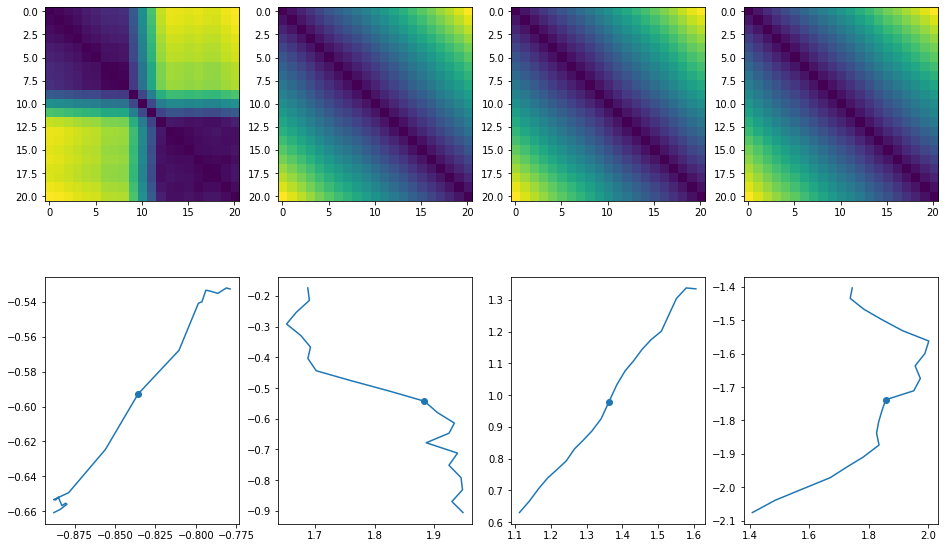

In [7]:
plt.figure(figsize=(16, 10))
idx = np.random.randint(0, len(train_set), 4)
c = Center()
k = -1
for i in idx:
    k += 1
    traj, matrix_dist, dive = c(train_set[i])

    plt.subplot(2,4, k+1)
    plt.imshow(matrix_dist)

    plt.subplot(2,4, k+5)
    plt.plot(traj[0,:], traj[1,:])
    i = int(window/2)
    if np.array(dive) == 1 :
        plt.scatter(traj[0,i], traj[1,i], c= 'orange')
    else:
      plt.scatter(traj[0,i], traj[1,i])

# Neural Network

In [8]:
# hyperparameters
batch_size = 512

## reduce size dataset
train_set = TrajDataSet(data_train_new, window, variable, transform = transforms.Compose([Center(), ToTensor()]))
validation_set = TrajDataSet(data_validation_new, window, variable, transform = transforms.Compose([Center(), ToTensor()]))

train_loader = DataLoader(train_set, batch_size=batch_size, num_workers = 0, shuffle = True, drop_last=True)
validation_loader = DataLoader(validation_set, batch_size=batch_size, num_workers = 0, shuffle = True, drop_last=True)

In [9]:
class FCNet(nn.Module):

    def __init__(self):
        super(FCNet, self).__init__()

        self.cnn = nn.Sequential(
            nn.Linear(3*21,100),
            nn.ReLU(),
            nn.Linear(100,500),
            nn.ReLU(),
            nn.Linear(500,500),
            nn.ReLU(),
            nn.Linear(500,500),
            nn.ReLU(),
            nn.Linear(500,1)
        )

    def forward(self, x):
        out = x.reshape((x.size()[0], 1, 3*21))
        out = self.cnn(out)
        return out

def get_score(out, y):
    out, y = out.cpu(), y.cpu()
    out = 1*(out>0)
    true_positive = np.mean(out[y == True].numpy()) 
    true_negative = 1-np.mean(out[y == False].numpy())
    
    return (round(true_positive*100) , round(true_negative*100))

In [10]:
# get sample
x, y, z = next(iter(train_loader)) 
weight = torch.FloatTensor([5])

# Forward model
model = FCNet()

out = model(x)

# Loss and score
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCEWithLogitsLoss(pos_weight = weight)
criterion(out, z)
get_score(out, z)

(100, 0)

In [11]:
## get Loss weight
torch.sum(z==z)/torch.sum(z)

tensor(2.5990)

## Training

In [12]:
# switch to GPU
model = FCNet()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
weight = weight.to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight = weight)

In [13]:
# Train the model
nb_epoch = 5

global_loss_train = []
global_loss_validation = []
    
for epoch in range(nb_epoch):
    learning_rate /= 10
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    i = 0
    for batch, (x, y, z) in enumerate(train_loader):
        i+=1
        # send to GPU
        x, y, z = x.to(device), y.to(device), z.to(device)

        # Run the forward pass
        out = model(x)
        loss = criterion(out, z)
        
        # Backprop and perform optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    ### Evaluation + Validation every epoch
    model.eval()
    with torch.no_grad():      
        j = 0
        # evaluation
        list_loss_train = []
        list_score_train = []
        for batch, (x, y, z) in enumerate(train_loader):
            j+= 1
            # send to GPU
            x, y, z = x.to(device), y.to(device), z.to(device)

            # Run the forward pass
            out =  model(x)
            loss = criterion(out, z)
            score = get_score(out,z)
            list_loss_train.append(loss.item())
            list_score_train.append(score)
        
        train_loss = np.mean(list_loss_train)
        train_trueP = np.mean([tp for (tp, tn) in list_score_train])
        train_trueN = np.mean([tn for (tp, tn) in list_score_train])
            
        k = 0
        # validation
        list_loss_validation = []
        list_score_validation = []
        for batch, (x, y, z) in enumerate(validation_loader):
            k+= 1
            # send to GPU
            x, y, z = x.to(device), y.to(device), z.to(device)

            # Run the forward pass
            out =  model(x)
            loss = criterion(out, z)
            score = get_score(out,z)
            list_loss_validation.append(loss.item())
            list_score_validation.append(score)

        validation_loss = np.mean(list_loss_validation)
        validation_trueP = np.mean([tp for (tp, tn) in list_score_validation])
        validation_trueN = np.mean([tn for (tp, tn) in list_score_validation])

    print('Epoch [{}/{}] -------------------------------------------------------------------------------------'
          .format(epoch+1, nb_epoch))
    print('Train Loss: {}, Train True Positive : {} %, Train True Negative : {} %'
            .format(round(train_loss, 2), round(train_trueP, 2), round(train_trueN, 2)))
    print('Validation Loss: {}, Validation True Positive : {} %, Validation True Negative : {} %'
            .format(round(validation_loss, 2), round(validation_trueP, 2), round(validation_trueN, 2)))
    model.train()
    
    global_loss_train.append(train_loss)
    global_loss_validation.append(validation_loss)

    #### STOP WHEN VALIDATION DECREASE
    if epoch>1:
      if global_loss_validation[-2] < global_loss_validation[-1]:
        break

Epoch [1/5] -------------------------------------------------------------------------------------
Train Loss: 0.57, Train True Positive : 97.78 %, Train True Negative : 69.44 %
Validation Loss: 0.55, Validation True Positive : 95.73 %, Validation True Negative : 78.82 %
Epoch [2/5] -------------------------------------------------------------------------------------
Train Loss: 0.54, Train True Positive : 97.94 %, Train True Negative : 70.88 %
Validation Loss: 0.49, Validation True Positive : 96.55 %, Validation True Negative : 81.0 %
Epoch [3/5] -------------------------------------------------------------------------------------
Train Loss: 0.53, Train True Positive : 97.18 %, Train True Negative : 73.64 %
Validation Loss: 0.51, Validation True Positive : 95.36 %, Validation True Negative : 82.73 %


## Testing

In [14]:
dive_estim = []
list_loss_test = []

for i in data_test_new.trip.unique():
    # create dataset for a trajectory
    t = data_test_new[data_test_new.trip == i].copy()    
    test_set = TrajDataSet(t, window, variable, transform = transforms.Compose([Center(), ToTensor()]))

    model.eval()
    estim = [0 for i in range(10)]
    k = 0
    with torch.no_grad():
        for (x, y, z) in test_set:
            # send to GPU
            x, y = x.to(device), y.to(device)

            # Run the forward pass
            out = model(x)
            
            loss = criterion(out.squeeze(1), z)
            list_loss_test.append(loss.item())
            estim.append(out.cpu().squeeze().numpy())

    estim = estim + [0 for i in range(10)]
    dive_estim.append(estim)



    print(i)
global_loss_test = np.mean(list_loss_test)
data_test_new['prediction'] = 1/(1+np.exp(-np.hstack(dive_estim)))

P1109_15_LB_T4
P1109_19_LB_T4
P1111_21_LB_T2
P1111_22_LB_T2
P1111_29_LB_T1
P1111_39_LB_T5
P1113_21_LB_T1
P1113_35_LB_T2


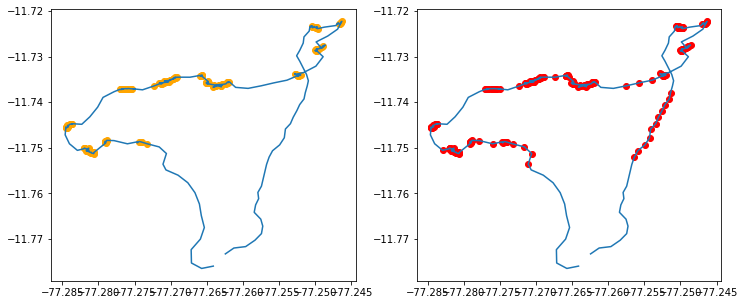

In [15]:
t = data_test_new[data_test_new.trip == 'P1109_15_LB_T4'].copy() 

plt.figure(figsize= (12, 5))
plt.subplot(1, 2, 1)
plt.plot(np.array(t.lon), np.array(t.lat))
plt.scatter(t.lon[t.dive == 1], t.lat[t.dive == 1], c = 'orange')

plt.subplot(1, 2, 2)
plt.plot(np.array(t.lon), np.array(t.lat))
plt.scatter(t.lon[t.prediction > 0.5], t.lat[t.prediction > 0.5], c = 'red')

# ROC curve

Change the decision threshold

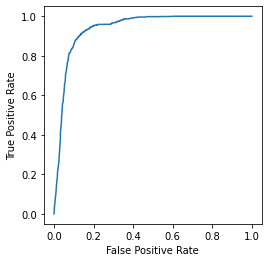

In [16]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

# globally
TP = []
FP = []

for tt in np.arange(0,1,0.001):
    all_estim = 1* (data_test_new.prediction > tt)
    true_positive = np.mean(all_estim[data_test_new.dive == 1])
    true_negative = 1-np.mean(all_estim[data_test_new.dive == 0])
    TP.append(true_positive)
    FP.append(1-true_negative)

plt.plot(np.array(FP), np.array(TP))

# Export Probabilities

In [17]:
# SAVE MODEL AND CONVERGENCE DATA
torch.save(model, 'LB_fcn_lonlatcov_15s.pt')

convergence_data = [global_loss_train, global_loss_validation, global_loss_test]
with open('LB_fcn_lonlatcov_15s.pickle', 'wb') as f:
    pickle.dump(convergence_data, f)

data_test_new.to_csv('LB_fcn_lonlatcov_15s.csv', index = False)